# Análise de votações na câmara dos deputados do Brasil (Governo FHC vs PT)
## Votações entre 1999 a 2002

Este é um trabalho para a classe Fundamentos da Matemática para Computação, UFABC, Professor Ronaldo.

Notas:
- Script utiliza como referência o script de análise de votação dos senadores;
- Os nomes dos deputados foram retirados para uma melhor visualização;
- Deputados com todos os dados de votos zerados foram removidos;
- As planilhas de dados são unidas pelos campos nome, partido e uf. Assim sendo, como os deputados podem trocar de partido durante o seu mandato, para fins de análise estes deputados constaram mais de uma vez na planilha final.

Importo as bibliotecas utilizadas para o processamento do script

In [104]:
import pandas as pd #dataframe lib
import matplotlib.pyplot as plt #plot lib
import glob # encontrar pathnames
import unicodedata # unicode parser
import numpy as np # processamento numérico
from numpy.linalg import svd
from collections import Counter
from scipy.spatial.distance import pdist,squareform # cálculo de distâncias


Esta linha é utilizada pelo Jupyter Notebook para formatar os gráficos gerados pelo matplotlib

In [105]:
%matplotlib inline

Carrega todos os dados da pasta "dados_camara" e mesclo tudo em um únido dataframe, dando um join nos dados pelas colunas: nome, partido e uf

In [106]:
votacoes = None
matchColumns = ["nome","partido","uf"]
files = ['./dados_camara/'+str(ano)+'.csv' for ano in range(1999,2002+1)]
#files = glob.glob('./dados_senado/*.csv')
for _file in files:
    aux = pd.read_csv(_file, encoding='utf-8')
    votacoes = aux if votacoes is None \
    else pd.merge(left=votacoes, right=aux, how="outer", left_on=matchColumns, right_on=matchColumns)

In [107]:
files

['./dados_camara/1999.csv',
 './dados_camara/2000.csv',
 './dados_camara/2001.csv',
 './dados_camara/2002.csv']

Preencho os valores nulos com zeros

In [108]:
votacoes.fillna(0, inplace=True)

In [109]:
psdb = votacoes[votacoes['partido'] == 'PSDB']
pt = votacoes[votacoes['partido'] == 'PT']
    
votacoes = pd.DataFrame().append(psdb).append(pt).reset_index(drop=True)

In [110]:
votacoes

,nome,partido,uf,MSC 1125/1998,MSC 1502/1998,MSC 627/1998,MSC 910/1997,MSC 99/1996,PDC 186/1999,PDC 233/1999,...,PL 6770/2002,PL 6770/2002.1,PLP 1/1991,PLP 275/2001,PLP 347/2002,PLP 347/2002.1,PLP 349/2002,PLP 349/2002.1,REC 211/2002,REC 238/2002
0,Jutahy Junior,PSDB,BA,1.0,0.0,0.0,1.0,-1.0,1.0,-1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0
1,João Almeida,PSDB,BA,1.0,0.0,0.0,1.0,-1.0,0.0,1.0,...,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,-1.0,-1.0
2,Leo Alcântara,PSDB,CE,1.0,0.0,0.0,1.0,-1.0,1.0,1.0,...,1.0,-1.0,0.0,0.0,1.0,1.0,1.0,1.0,-1.0,0.0
3,Antonio Cambraia,PSDB,CE,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0
4,Rommel Feijó,PSDB,CE,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,-1.0,-1.0
5,Manoel Salviano,PSDB,CE,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0
6,Vicente Arruda,PSDB,CE,0.0,1.0,0.0,0.0,-1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0
7,Jovair Arantes,PSDB,GO,1.0,1.0,0.0,1.0,-1.0,1.0,1.0,...,0.0,-1.0,1.0,1.0,0.0,0.0,0.0,0.0,-1.0,-1.0
8,Sebastião Madeira,PSDB,MA,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0
9,João Castelo,PSDB,MA,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.0,-1.0


Seleciono os votos que não tem series zeradas e seleciono as votacões com base nestes votos filtrados

In [111]:
votos = votacoes.iloc[:,3:votacoes.shape[1]]
votos = votos[(votos.T != 0).any()].reset_index(drop=True)
votacoes = votacoes.iloc[votos.index.tolist(),:].reset_index(drop=True)

Seleciono os estados e converto o formato para unicode

In [112]:
estados = votacoes.uf
estados = pd.Series([unicodedata.normalize("NFKD", e).strip() for e in estados])

Separado os estados por regiões

In [113]:
estados_regioes = {('SP','MG','RJ','ES') : 'SE' ,
           ('DF','MT','MS','GO') : 'CO' ,
           ('RS','PR','SC') : 'SU' ,
           ('AL','BA','CE','MA','PB','PE','PI','RN','SE') : 'NE',
           ('AC','AP','AM','PA','RO','RR','TO') : 'NO'}

In [114]:
regioes = pd.Series([estados_regioes[k] for e in estados for k in estados_regioes.keys()  if e in k])

Seleciono deputados e partidos

In [115]:
deputados = votacoes.nome

In [116]:
partidos = votacoes.partido

In [117]:
votacoes.shape

(267, 433)

Calculo a matriz de correspondência

In [118]:
corr = np.corrcoef(votos)

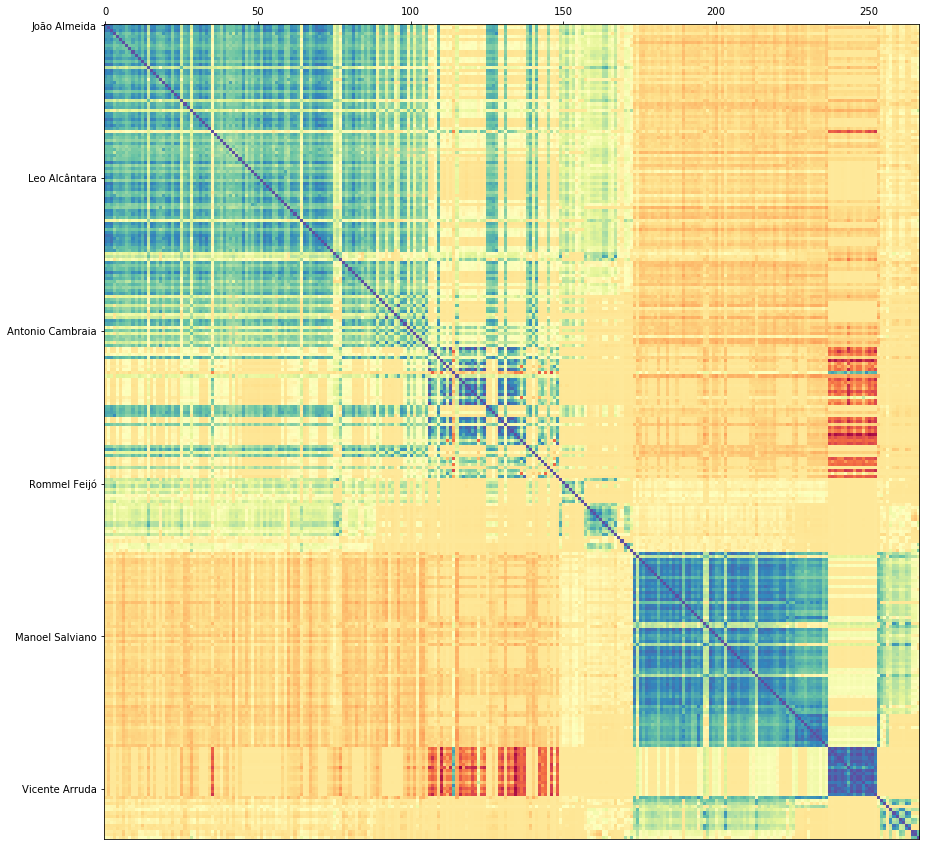

In [119]:
fig,ax = plt.subplots(figsize=(20,15))
ax.imshow(corr,cmap=plt.get_cmap('Spectral'))
#ax.set_yticks(range(len(deputados)))
ax.set_yticklabels(deputados)
#ax.set_xticks(range(len(deputados)))
#ax.set_xticklabels(deputados,rotation=90)
ax.xaxis.tick_top()
plt.show()

## Análise de afinidade

In [120]:
U, Sigma, V = svd(corr)

In [121]:
afinidade = U[:,0]

In [122]:
cut =  np.sum(afinidade < np.mean(afinidade)) - 0.5

In [123]:
iafinidade = np.argsort(afinidade)
corr_afinidade = corr[iafinidade,:]
corr_afinidade = corr_afinidade[:,iafinidade]

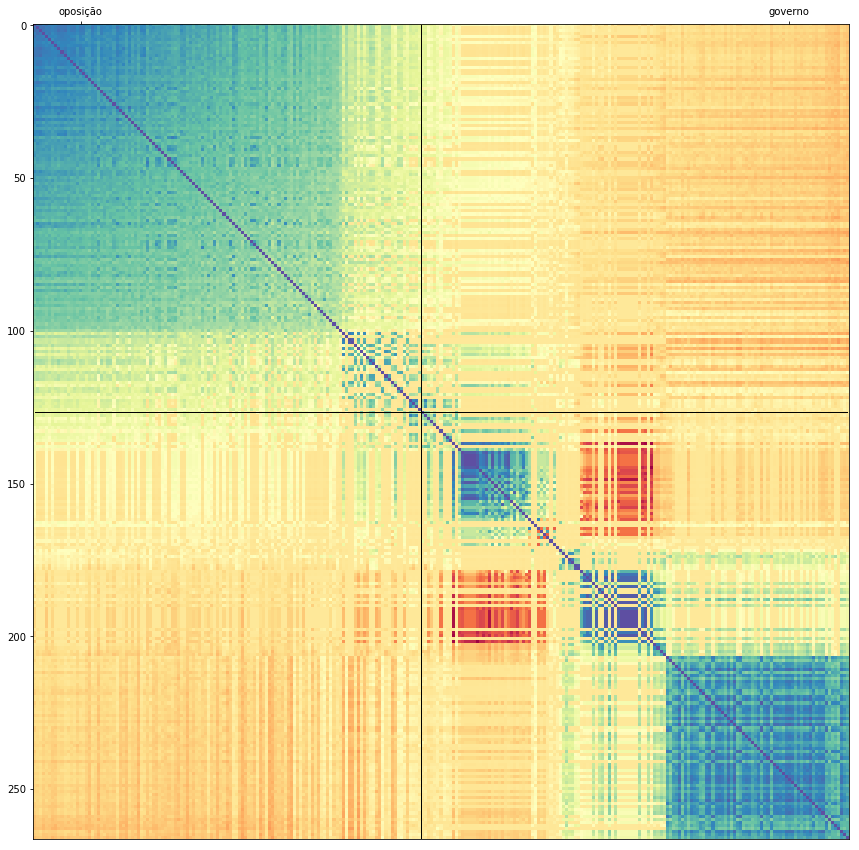

In [124]:
fig,ax = plt.subplots(figsize=(20,15))
ax.imshow(corr_afinidade,cmap=plt.get_cmap('Spectral'))
ax.plot([0,deputados.shape[0]-1],[cut,cut],color='black',lw=1)
ax.plot([cut,cut],[0,deputados.shape[0]-1],color='black',lw=1)
ax.set_xticks([15,deputados.shape[0]-20])
#ax.set_yticks(range(len(deputados)))
ax.set_xticklabels([u"oposição",u"governo"])
#ax.set_yticklabels(deputados[iafinidade])
ax.xaxis.tick_top()
plt.show()

In [125]:
part_ord = np.lexsort([iafinidade,partidos])
corr_partido = corr[part_ord,:]
corr_partido = corr_partido[:,part_ord]

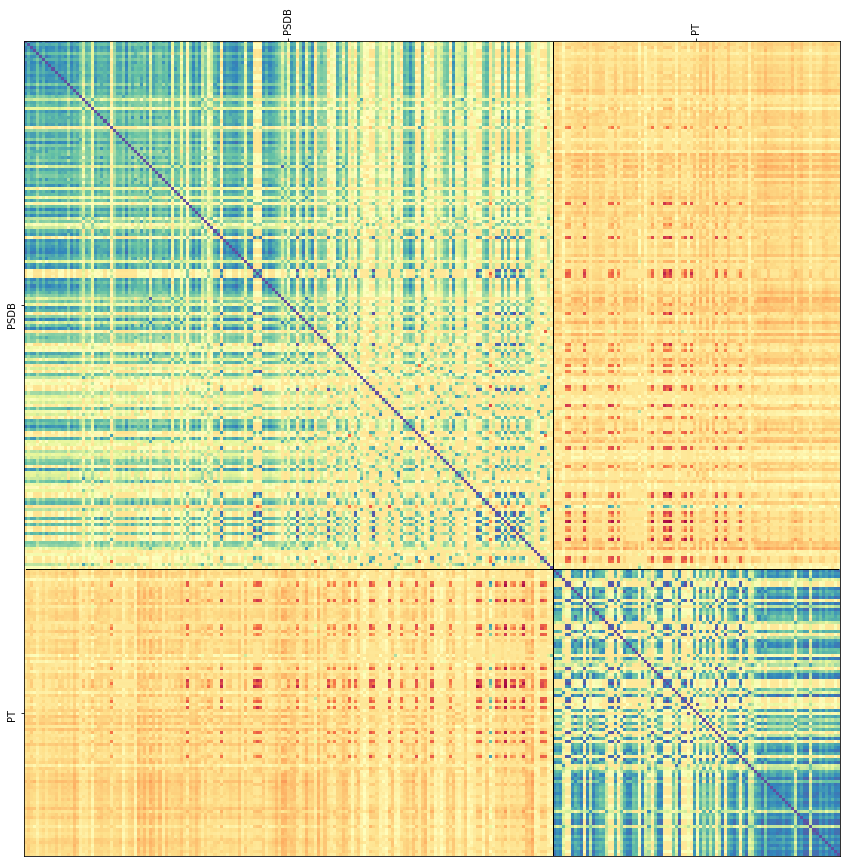

In [126]:
splits = [i for i in range(len(partidos)-1) if partidos.iloc[i] != partidos.iloc[i+1]]
fig,ax = plt.subplots(figsize=(20,15))
partido_ord=pd.Series(partidos[part_ord].reset_index(drop=True))
splits = [i for i in range(len(partido_ord)-1) if partido_ord.iloc[i] != partido_ord.iloc[i+1]]
cj_partidos = set(partido_ord) 

pos = [np.mean(np.where(partido_ord==p))  for p in cj_partidos]

ax.imshow(corr_partido ,cmap=plt.get_cmap('Spectral'))
for i in splits:
    ax.plot([0,deputados.shape[0]-1],[i+0.5,i+0.5],color='black',lw=1)
    ax.plot([i+0.5,i+0.5],[0,deputados.shape[0]-1],color='black',lw=1)

ax.set_xticks(pos)
#ax.set_yticks(range(len(deputados)))
ax.set_xticklabels(cj_partidos,rotation=90)

ax.set_yticks(pos)
ax.set_yticklabels(cj_partidos,rotation=90)

#ax.set_yticklabels(deputados[part_ord])
ax.xaxis.tick_top()


plt.show()    

In [127]:
part_ord = np.lexsort([iafinidade,partidos])
corr_partido = corr[part_ord,:]
corr_partido = corr_partido[:,part_ord]

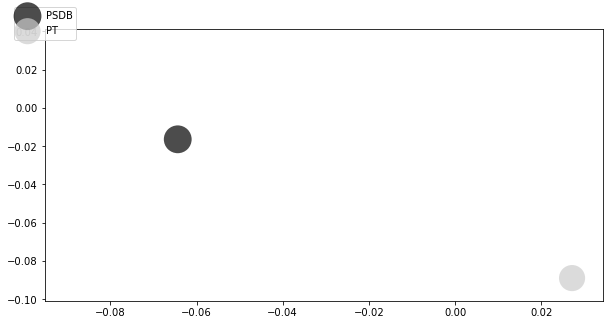

In [128]:
rgb_values = plt.get_cmap("nipy_spectral", len(cj_partidos))
colors = [rgb_values(i) for i in range(len(cj_partidos))]
cmap = dict(zip(cj_partidos,colors))
counts = Counter(partidos)

fig, ax = plt.subplots(figsize=(10,5))
for p in cj_partidos:
    pts = partidos[partidos==p].index
    ax.scatter(np.mean(U[pts,0]),np.mean(U[pts,1]), c=cmap[p], s = np.log(counts[p]+1)*150, label=p,
               alpha=0.7, edgecolors='none')

ax.legend(loc=9,ncol=(len(cj_partidos)+1)//2,bbox_to_anchor=(0, 1.1))
plt.show()

## Análise de regiões

In [129]:
reg_ord = np.lexsort([iafinidade,regioes])
corr_regiao = corr[reg_ord,:]
corr_regiao = corr_regiao[:,reg_ord]

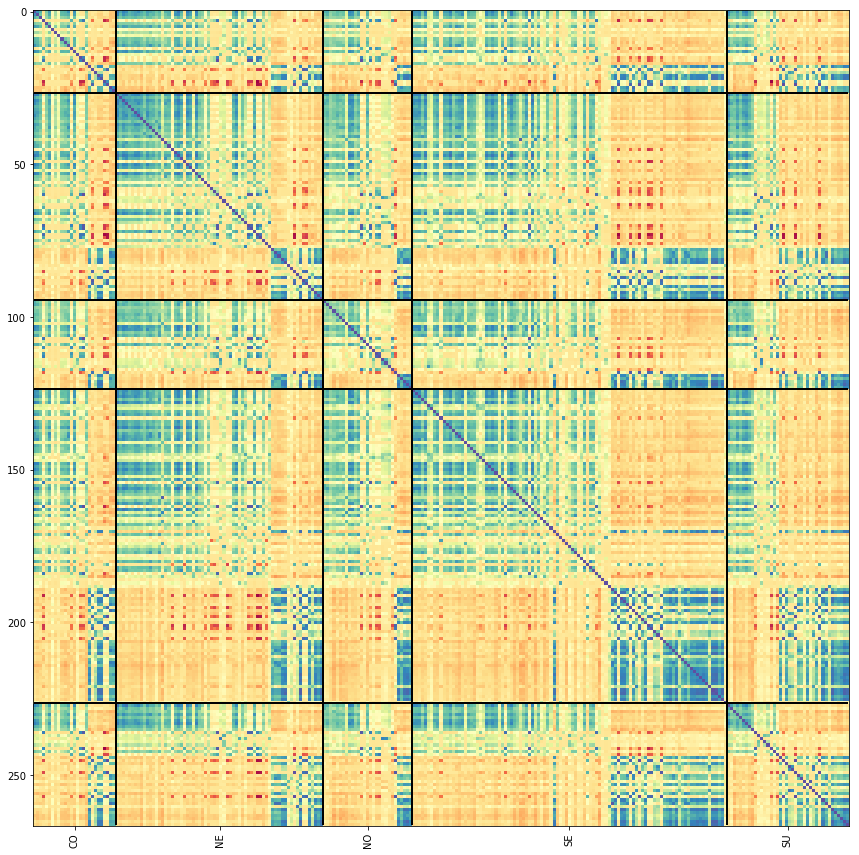

In [130]:
fig,ax = plt.subplots(figsize=(20,15))
regioes_ord = pd.Series(regioes[reg_ord].reset_index(drop=True))
splits = [i for i in range(len(regioes_ord)-1) if regioes_ord[i] != regioes_ord[i+1]]
cj_regioes = set(regioes_ord) 
pos = [np.mean(np.where(regioes_ord==p))  for p in cj_regioes]

ax.imshow(corr_regiao,cmap=plt.get_cmap('Spectral'))
for i in splits:
    ax.plot([0,votos.shape[0]-1],[i+0.5,i+0.5],color='black',lw=2)
    ax.plot([i+0.5,i+0.5],[0,votos.shape[0]-1],color='black',lw=2)
    
ax.set_xticks(pos)
#ax.set_yticks(range(len(deputados)))
ax.set_xticklabels(cj_regioes,rotation=90)
#ax.set_yticklabels(deputados[reg_ord])
plt.show()

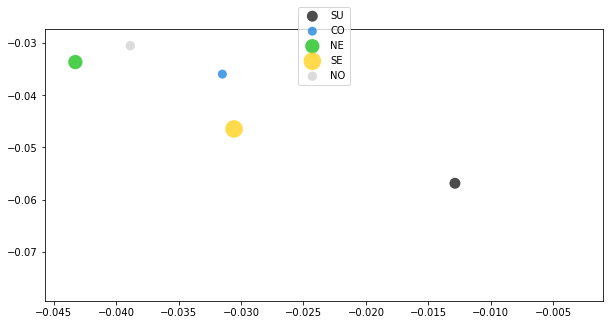

In [131]:
rgb_values = plt.get_cmap("nipy_spectral", len(cj_regioes))
colors = [rgb_values(i) for i in range(len(cj_regioes))]
cmap = dict(zip(cj_regioes,colors))
counts = Counter(regioes)

fig, ax = plt.subplots(figsize=(10,5))
for p in cj_regioes:
    pts = regioes[regioes==p].index
    ax.scatter(np.mean(U[pts,0]),np.mean(U[pts,1]), c=cmap[p], s = counts[p]*3, label=p,
               alpha=0.7, edgecolors='none')

ax.legend(loc=9,ncol=(len(cj_partidos)+1)//2,bbox_to_anchor=(0.5, 1.1))
plt.show()

## Previsão de votação

In [132]:
acertos = []
por_partido = {
    'PT' : [],
    'PSDB' : [],
}
for votacao in range(1,votos.shape[1]):
    d = squareform(pdist(votos.iloc[:,range(votacao)]))
    np.fill_diagonal(d,float('inf'))
    nn = [np.random.choice(np.argwhere(d[i,:] == np.amin(d[i,:]))[0]) for i in range(len(d))] 
    prediction = votos.iloc[nn,votacao].reset_index(drop=True)
    acertos.append(np.mean(prediction == votos.iloc[:,votacao]))
    for p in por_partido.keys():
        sset = np.where(partidos==p)[0]
        por_partido[p].append(np.mean(prediction.iloc[sset] == votos.iloc[sset,votacao]))

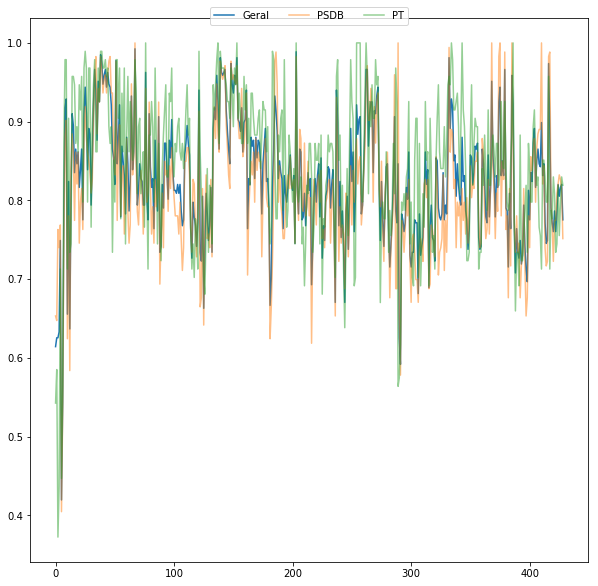

In [133]:
fig, ax = plt.subplots(figsize=(10,10))

ax.plot(acertos,label="Geral")
for p in por_partido.keys():
    ax.plot(por_partido[p],label=p,alpha=0.5)
ax.legend(loc=9,ncol=4,bbox_to_anchor=(0.5, 1.03))
plt.show()